In [ ]:
using Pkg
Pkg.activate("NB04")
Pkg.update()

In [ ]:
using Plots, LinearAlgebra, Images
using MLDatasets
using Flux # Interface für neuronale Netze 

# Klassifikation durch ein neuronales Netz

Wir verwenden wieder den [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) Datensatz von [Zalando Research](https://github.com/zalandoresearch).

Der Datensatz enthält Bilder aus 10 Kategorien. Diese wollen wir vorhersagen.

In [3]:
X, Y = FashionMNIST()[:];

`X` enthält nun die Eingabedaten (die Bilder der Fashion Items) und `Y` enthält die Label. 

Die Einträge von `Y` sind Zahlen von $0-9$. Da `Julia` Indexierung bei `1` anfängt, addieren wir außerdem 1 zu allen Einträgen von `Y`. 

In [4]:
input_data = X
output_data = Y .+ 1;

Die Einträge von `output_data` kodieren dann die folgenden Items.

In [5]:
labels = ["T-shirt/top", 
            "Trouser", 
            "Pullover", 
            "Dress", 
            "Coat", 
            "Sandal", 
            "Shirt", 
            "Sneaker", 
            "Bag", 
            "Ankle boot"];
n_categories = length(labels);

Die Anzahl der Datenpunkte im Datensatz ist 

In [6]:
N = length(Y)

60000

Wir betrachten 6 zufällige Items aus dem Datensatz:

["Sneaker", "Pullover", "Ankle boot", "Dress", "Sneaker", "Trouser"]


,,,,,

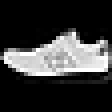
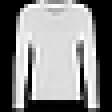
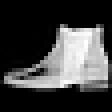
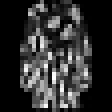
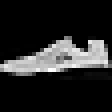
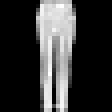

In [7]:
k = rand(1:N, 6)
println(["$(labels[output_data[i]])" for i in k])
[convert2image(FashionMNIST, X[:,:,i]) for i in k]

## Trainings- und Testdaten

Wir teilen nun die Daten in Trainings- und Testdaten auf.

Wir nehmen $75\%$ der Daten zum Training.

In [8]:
k = floor(0.75 * N) |> Int
input_train = input_data[:, :, 1:k]
output_train = output_data[1:k]
input_test = input_data[:, :, k+1:end]
output_test = output_data[k+1:end];

## Visualisierung der Geometrie der Daten

Jedes Eingabedatum ist ein Graubild mit $28\times 28$ Pixeln, also ein Punkt in $\mathbb R^d$ mit 

$$ d = 28^2 = 784.$$

In [9]:
d = 28^2

784

Der Datentyp der Eingabedaten ist

In [10]:
typeof(input_data[:,:,1])

Matrix{Float32} (alias for Array{Float32, 2})

Um die Daten einem neuronalen Netz zu übergeben, vektorisieren wir sie zunächst.

In [11]:
input_train_vec = [vec(input_train[:,:,i]) for i in 1:k];
input_test_vec = [vec(input_test[:,:,i]) for i in 1:N-k];

Wir können die Daten nun visualisieren, indem wir sie mit einer zufälligen Matrix $P\in \mathbb R^{2\times d}$  multiplizeren:

In [12]:
P = randn(2, d)
pts_2D = map(x -> P * x, input_test_vec);

und dann plotten (wir plotten nur die ersten 200 Datenpunkte).

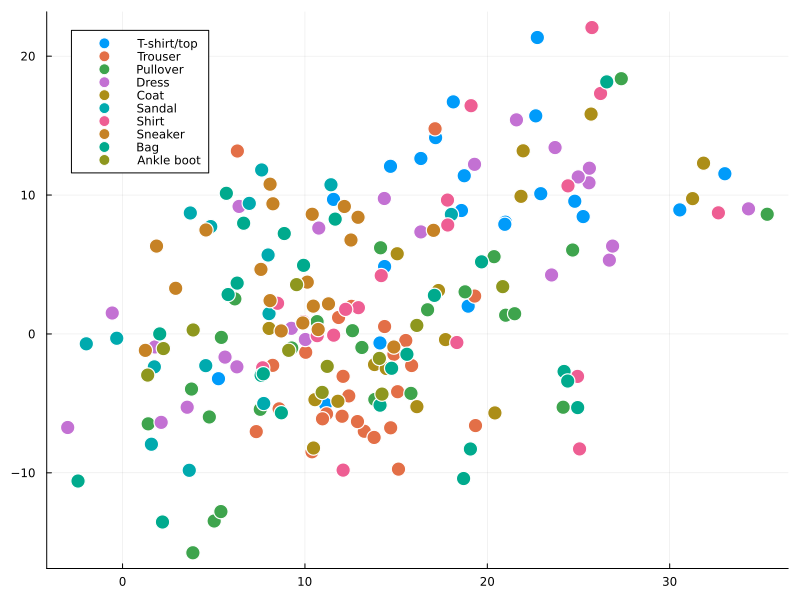

In [13]:
h = 200
pts_plot = pts_2D[1:h]; labels_plot = output_test[1:h];
plot()
for i in 1:n_categories
    item = labels_plot .== i
    scatter!(Tuple.(pts_plot[item]), 
                label = labels[i],
                size = (800,600),
                markerstrokecolor = :white, markersize = 8)
end
plot!()

# Neural Networks

Wir definieren nun ein neuronales Netz zur Klassifikation. 

Dazu benutzen wir [Flux.jl](https://fluxml.ai), welches ein simples Interface für neuronale Netze bietet. 

Wir definieren ein neuronales Netz mit fünf Schichten:

$$\mathbb R^d\to\mathbb R^{n_1}\to\mathbb R^{n_2}\to\mathbb R^{n_3}\to\mathbb R^{s}$$ 

(wobei $s$ = Anzahl Kategorien).

Die Ausgabe in $\mathbb R^{s}$ wird eine Wahrscheinlichkeitsverteilung auf den Fashion Items sein. Daher verwenden wir nach der letzten Schicht eine SoftMax Aktivierungsfunktion. Die anderen Aktivierungsfunktionen sind ReLU. 

In [14]:
n_categories

10

In [15]:
n1, n2, n3 = 900, 200, 100

M = Flux.Chain(
          Dense(d, n1, relu),
          Dense(n1, n2, relu),
          Dense(n2, n3, relu),
          Dense(n3, n_categories),
          softmax)

Chain(
  Dense(784 => 900, relu),              # 706_500 parameters
  Dense(900 => 200, relu),              # 180_200 parameters
  Dense(200 => 100, relu),              # 20_100 parameters
  Dense(100 => 10),                     # 1_010 parameters
  NNlib.softmax,
)                   # Total: 8 arrays, 907_810 parameters, 3.463 MiB.

Wir müssen nun die gegebenen Ausgabedaten ebenfalls in Wahrscheinlichkeitsverteilungen transformieren.

In [16]:
output_train_vec = map(output_train) do Yᵢ
    p = zeros(Float64, n_categories)
    p[Yᵢ] = 1
    p
end;
output_test_vec = map(output_test) do Yᵢ
    p = zeros(Float64, n_categories)
    p[Yᵢ] = 1
    p
end;

Als Verlustfunktion nehmen wir [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) 

$$\ell(\hat y,y) = -\sum_{i=1}^{s} y_i\cdot \log(\hat y_i).$$

In [17]:
ℓ(ŷ, y) = Flux.crossentropy(ŷ, y; dims = n_categories);

## Training unseres Modells
Wir sind nun bereit das neuronale Netz zu trainineren:

In [18]:
dataset = zip(input_train_vec, output_train_vec) |> collect;
opt = Flux.setup(Adam(), M);

In [ ]:
Flux.train!(M, dataset, opt) do m, x, y
  ℓ(m(x), y)
end

Wir evaluieren das empirische Risiko für die Test- und Trainingsdaten:

In [ ]:
R_train = sum(ℓ(M(x), y) for (x,y) in zip(input_train_vec, output_train_vec)) / k;
R_test = sum(ℓ(M(x), y) for (x,y) in zip(input_test_vec, output_test_vec)) / k;
R_train, R_test

## Ergebnis

Wir schauen nun, wie unser Modell performt.

In [ ]:
l = rand(1:N-k)
println("\n Richtiges Label: $(labels[output_test[l]]).")
convert2image(FashionMNIST, input_test[:,:,l])

In [ ]:
input = input_test_vec[l]
out = M(input);

In [ ]:
p = sortperm(out; rev = true)
for j in p
    w = round(100 * out[j]; digits = 2)
    println("Mit Wahrscheinlichkeit $w %: $(labels[j])")
end
convert2image(FashionMNIST, input_test[:,:,l])

## Noch einmal Visualisierung

Wir visualieren noch einmal die Daten, aber diesmal mit den von unserem Modell vorhergesagten Labels.

Dabei soll die Punktgröße abhängig von der vom Modell vorhergesagten Wahrscheinlichkeit sein (je wahrscheinlicher desto größer der Punkt).

In [ ]:
sizes = map(x -> maximum(M(x)), input_test_vec) .* 6
Ŷ = map(x -> argmax(M(x)), input_test_vec);

In [ ]:
h = 200
pts_plot = pts_2D[1:h]; labels_plot = output_test[1:h]; Ŷ_plot = Ŷ[1:h]
plot(layout = 2)
for i in 1:n_categories
    item = labels_plot .== i
    prediction = Ŷ_plot .== i
    scatter!(Tuple.(pts_plot[item]), 
                label = labels[i],
                size = (800,400),
                subplot = 1, 
                xlabel = "Richtige Labels")
    scatter!(Tuple.(pts_plot[prediction]), 
                label = labels[i],
                size = (800,400),
                subplot = 2,
                xlabel = "Vorhergesagte Labels")
end
plot!()

Insgesamt haben wir den folgenden Prozentsatz der Labels in den Testdaten korrekt vorhergesagt:

In [ ]:
j = count(Ŷ .== output_test) / length(output_test)
print("Anteil der korrekten Vorhersagen: ", round(j * 100, digits = 2), " %.")

# Klassifikation von MNIST

Gehen Sie das Notebook noch einmal durch, aber anstatt des `FashionMNIST` Datensatzes verwenden Sie den `MNIST` Datensatz:

In [ ]:
#X, Y = MNIST()[:];